<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/VGG19_SEVERE/vgg19_severity_another_try_sevrrity_main_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
80134624/80134624 [==============================] - 3s 0us/step


Epoch 1/10
52/52 [==============================] - 343s 6s/step - loss: 2.9842 - accuracy: 0.4903 - val_loss: 0.6883 - val_accuracy: 0.6477
Epoch 2/10
52/52 [==============================] - 15s 286ms/step - loss: 0.7194 - accuracy: 0.6711 - val_loss: 0.8117 - val_accuracy: 0.6136
Epoch 3/10
52/52 [==============================] - 15s 292ms/step - loss: 0.6740 - accuracy: 0.6845 - val_loss: 0.9053 - val_accuracy: 0.5625
Epoch 4/10
52/52 [==============================] - 15s 292ms/step - loss: 0.6373 - accuracy: 0.7100 - val_loss: 0.6737 - val_accuracy: 0.6534
Epoch 5/10
52/52 [==============================] - 15s 289ms/step - loss: 0.6253 - accuracy: 0.7124 - val_loss: 0.8259 - val_accuracy: 0.6080
Epoch 6/10
52/52 [==============================] - 15s 289ms/step - loss: 0.5725 - accuracy: 0.7549 - val_loss: 0.9618 - val_accuracy: 0.6193
Epoch 7/10
52/52 [==============================] - 15s 295ms/step - loss: 0.5329 - accuracy: 0.7852 - val_loss: 0.7362 - val_accuracy: 0.6591
E

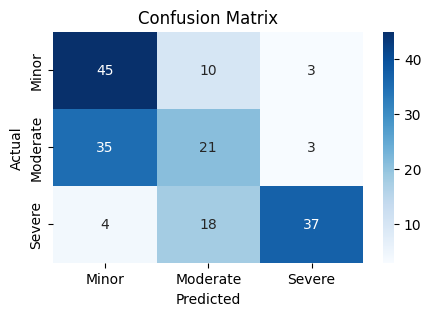

Test loss: 0.9180
Test accuracy: 59.66
Train loss: 0.4784
Train accuracy: 80.77
Recall: 0.59
Precision: 0.61
F1-score: 0.58


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/severity main/train'
val_dir = '/content/drive/MyDrive/severity main/validation'
test_dir = '/content/drive/MyDrive/severity main/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16  # Increase batch size for faster convergence

# Create data generators with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce shift range
    height_shift_range=0.1,  # Reduce shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduce dropout rate
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vehicle_severity_10epochs_dataset_severitymain_damage_VGG19_updated.h5')


Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


Epoch 1/60
52/52 [==============================] - 16s 290ms/step - loss: 1.9184 - accuracy: 0.5206 - val_loss: 0.8090 - val_accuracy: 0.6307
Epoch 2/60
52/52 [==============================] - 16s 302ms/step - loss: 0.7564 - accuracy: 0.6432 - val_loss: 0.6342 - val_accuracy: 0.7045
Epoch 3/60
52/52 [==============================] - 15s 296ms/step - loss: 0.6822 - accuracy: 0.7002 - val_loss: 0.7530 - val_accuracy: 0.6080
Epoch 4/60
52/52 [==============================] - 15s 297ms/step - loss: 0.6501 - accuracy: 0.7039 - val_loss: 0.6369 - val_accuracy: 0.7159
Epoch 5/60
52/52 [==============================] - 16s 308ms/step - loss: 0.6260 - accuracy: 0.7318 - val_loss: 1.1295 - val_accuracy: 0.5057
Epoch 6/60
52/52 [==============================] - 15s 296ms/step - loss: 0.6000 - accuracy: 0.7245 - val_loss: 0.7318 - val_accuracy: 0.6818
Epoch 7/60
52/52 [==============================] - 16s 297ms/step - loss: 0.5820 - accuracy: 0.7451 - val_loss: 0.9189 - val_accuracy: 0.5852

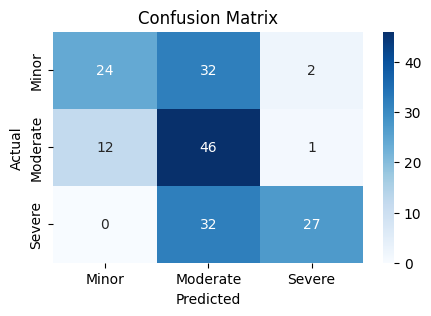

Test loss: 1.5710
Test accuracy: 54.55
Train loss: 0.2584
Train accuracy: 89.42
Recall: 0.55
Precision: 0.66
F1-score: 0.55


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/severity main/train'
val_dir = '/content/drive/MyDrive/severity main/validation'
test_dir = '/content/drive/MyDrive/severity main/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16  # Increase batch size for faster convergence

# Create data generators with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce shift range
    height_shift_range=0.1,  # Reduce shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduce dropout rate
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=60,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vehicle_severity_60epochs_dataset_severitymain_damage_VGG19_updated.h5')


Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


Epoch 1/60
26/26 [==============================] - 21s 532ms/step - loss: 3.3127 - accuracy: 0.4851 - val_loss: 1.2518 - val_accuracy: 0.5625
Epoch 2/60
26/26 [==============================] - 21s 831ms/step - loss: 0.7550 - accuracy: 0.6559 - val_loss: 0.7330 - val_accuracy: 0.6313
Epoch 3/60
26/26 [==============================] - 14s 548ms/step - loss: 0.6548 - accuracy: 0.7215 - val_loss: 0.6669 - val_accuracy: 0.7125
Epoch 4/60
26/26 [==============================] - 14s 540ms/step - loss: 0.6340 - accuracy: 0.7166 - val_loss: 0.6812 - val_accuracy: 0.7188
Epoch 5/60
26/26 [==============================] - 14s 549ms/step - loss: 0.6078 - accuracy: 0.7500 - val_loss: 1.0589 - val_accuracy: 0.5375
Epoch 6/60
26/26 [==============================] - 14s 551ms/step - loss: 0.6316 - accuracy: 0.7153 - val_loss: 0.7583 - val_accuracy: 0.6500
Epoch 7/60
26/26 [==============================] - 15s 562ms/step - loss: 0.5192 - accuracy: 0.7847 - val_loss: 0.7302 - val_accuracy: 0.6687

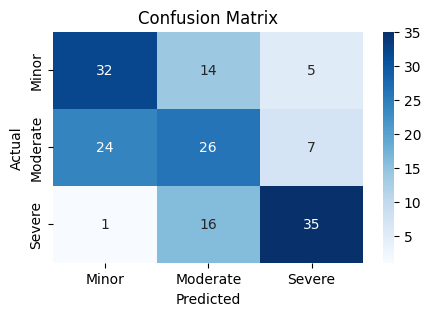

Test loss: 1.0565
Test accuracy: 61.25
Train loss: 0.1592
Train accuracy: 93.39
Recall: 0.59
Precision: 0.59
F1-score: 0.59


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/severity main/train'
val_dir = '/content/drive/MyDrive/severity main/validation'
test_dir = '/content/drive/MyDrive/severity main/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32  # Increase batch size for faster convergence

# Create data generators with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce shift range
    height_shift_range=0.1,  # Reduce shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduce dropout rate
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=60,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vehicle_severity_60epochs_dataset_severitymain_damage_VGG19_updated.h5')


Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


Epoch 1/60
26/26 [==============================] - 17s 559ms/step - loss: 3.9547 - accuracy: 0.4641 - val_loss: 0.6603 - val_accuracy: 0.7125
Epoch 2/60
26/26 [==============================] - 14s 542ms/step - loss: 0.8178 - accuracy: 0.6597 - val_loss: 0.6650 - val_accuracy: 0.6750
Epoch 3/60
26/26 [==============================] - 15s 555ms/step - loss: 0.7052 - accuracy: 0.6881 - val_loss: 0.7480 - val_accuracy: 0.6438
Epoch 4/60
26/26 [==============================] - 15s 572ms/step - loss: 0.6323 - accuracy: 0.7252 - val_loss: 0.7501 - val_accuracy: 0.6062
Epoch 5/60
26/26 [==============================] - 15s 548ms/step - loss: 0.6047 - accuracy: 0.7488 - val_loss: 0.6549 - val_accuracy: 0.6938
Epoch 6/60
26/26 [==============================] - 15s 558ms/step - loss: 0.5985 - accuracy: 0.7413 - val_loss: 0.6340 - val_accuracy: 0.6812
Epoch 7/60
26/26 [==============================] - 14s 546ms/step - loss: 0.5495 - accuracy: 0.7673 - val_loss: 0.7955 - val_accuracy: 0.6438

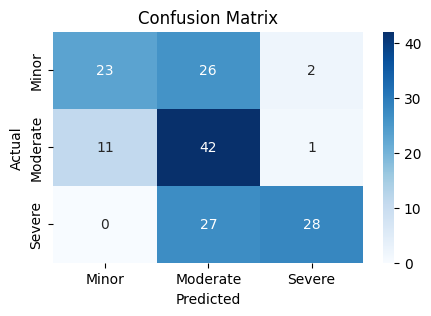

Test loss: 1.0176
Test accuracy: 58.75
Train loss: 0.1900
Train accuracy: 91.83
Recall: 0.5793
Precision: 0.6739
F1-score: 0.5854


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/severity main/train'
val_dir = '/content/drive/MyDrive/severity main/validation'
test_dir = '/content/drive/MyDrive/severity main/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32  # Increase batch size for faster convergence

# Create data generators with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce shift range
    height_shift_range=0.1,  # Reduce shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduce dropout rate
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=60,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-score: {f1:.4f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vehicle_severity_60epochs_dataset_32batch_morelayer_severitymain_damage_VGG19_updated.h5')


Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


Epoch 1/50
26/26 [==============================] - 23s 663ms/step - loss: 7.4389 - accuracy: 0.3255 - val_loss: 1.1005 - val_accuracy: 0.3375
Epoch 2/50
26/26 [==============================] - 17s 673ms/step - loss: 1.1041 - accuracy: 0.3255 - val_loss: 1.0991 - val_accuracy: 0.3250
Epoch 3/50
26/26 [==============================] - 18s 693ms/step - loss: 1.0990 - accuracy: 0.3082 - val_loss: 1.0988 - val_accuracy: 0.3438
Epoch 4/50
26/26 [==============================] - 17s 652ms/step - loss: 1.0988 - accuracy: 0.3564 - val_loss: 1.0985 - val_accuracy: 0.3313
Epoch 5/50
26/26 [==============================] - 18s 676ms/step - loss: 1.0986 - accuracy: 0.3304 - val_loss: 1.0988 - val_accuracy: 0.3250
Epoch 6/50
26/26 [==============================] - 17s 650ms/step - loss: 1.0986 - accuracy: 0.3428 - val_loss: 1.0984 - val_accuracy: 0.3438
Epoch 7/50
26/26 [==============================] - 18s 675ms/step - loss: 1.0990 - accuracy: 0.3243 - val_loss: 1.0989 - val_accuracy: 0.3187

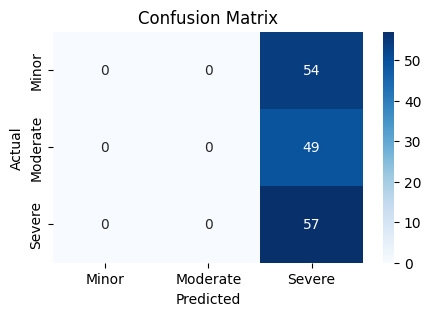

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Recall: 0.3333
Precision: 0.1188
F1-score: 0.1751


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/severity main/train'
val_dir = '/content/drive/MyDrive/severity main/validation'
test_dir = '/content/drive/MyDrive/severity main/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Create data generators with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG19
x = base_model.output
x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune some layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = True

# Compile the model with reduced learning rate
model.compile(optimizer=Adam(lr=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Print results
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')

# Calculate metrics
y_true = []
y_pred = []
for _ in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-score: {f1:.4f}')

# Save the model
model.save('/content/drive/MyDrive/colabtest/vehicle_severity_VGG19_updated_50epochs_severitymain_dataset.h5')
